#**Task 2 of your assignment involves training a custom object detection model on the provided dataset. Here's a step-by-step process:**

**1. Dataset Preparation:** Divide the provided dataset into training, validation, and test sets. Ensure you have the images and their corresponding annotations ready in a format suitable for training.

**2. Model Architecture Selection:** Use the same pre-trained object detection model from Task 1. If you used Fast R-CNN with ResNet-50 FPN, you'll continue with that.

**3. Model Modification:** Adjust the model's final layers if necessary to match the number of classes in your dataset.

**4. Training Setup:** Configure your training parameters, including the learning rate, batch size, and the number of epochs. Also, set up your loss function and optimizer.

**5. Model Training:** Train the model on your training dataset while validating its performance on the validation set to fine-tune hyperparameters and avoid overfitting.

**6. Model Evaluation:** After training, evaluate the model's performance on the test set to measure its accuracy and effectiveness in detecting objects.

**7. Visualization:** For each image in the test set, display the image with the detected objects and their corresponding bounding boxes as you did in Task 1.

Mapping of the Categories of the COCO Dataset can be found at the [link](https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/).

##**1. Dataset Preparation**

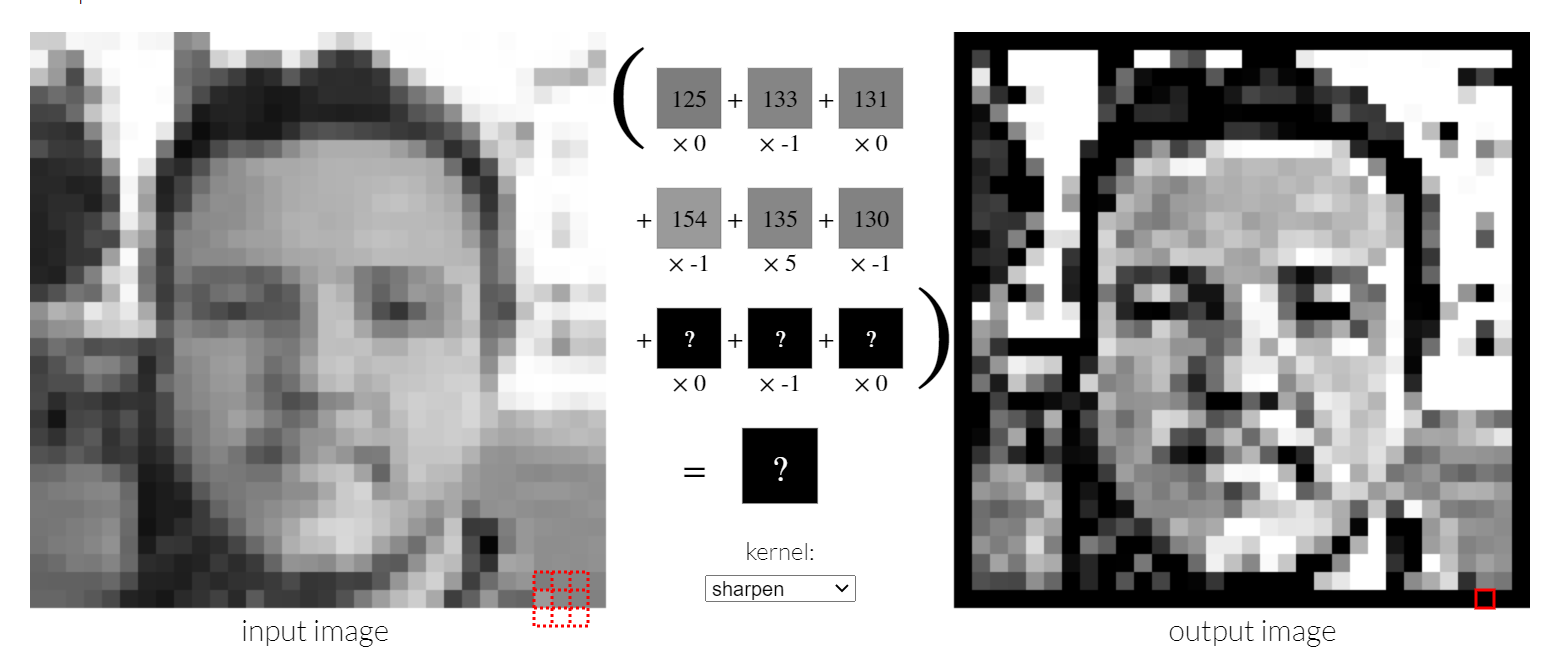

###**1.1 Annotation Parsing**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import os
from tqdm import tqdm

In [3]:
# Path to the annotations directory
annotations_dir = '/content/drive/MyDrive/MAVISOFT/INPUT_DATASET/CV_Dataset/train2017/'

In [4]:
# Dictionary to store aggregated annotations by image_id
annotations_by_image = {}

In [5]:
# Iterate over each JSON file and parse it
for file_name in tqdm(os.listdir(annotations_dir), desc = 'Parsing Annotations'):
    if file_name.endswith('.json'):
        file_path = os.path.join(annotations_dir, file_name)
        with open(file_path, 'r') as f:
            annotations = json.load(f)
            for annotation in annotations:
                image_id = annotation['image_id']
                bbox = annotation['bbox']
                category_id = annotation['category_id']
                image_path = f"/content/drive/MyDrive/MAVISOFT/INPUT_DATASET/CV_Dataset/train2017/{image_id:012}.jpg"

                # Aggregate annotations by image_id
                if image_id not in annotations_by_image:
                    annotations_by_image[image_id] = {'image_path': image_path, 'annotations': []}
                # annotations_by_image[image_id]['annotations'].append({'bbox': bbox, 'category_id': category_id})
                annotations_by_image[image_id]['annotations'].append({'boxes': bbox, 'labels': category_id})

Parsing Annotations: 100%|██████████| 5030/5030 [01:56<00:00, 43.01it/s] 


In [6]:
# Convert the aggregated annotations into a list for easier processing
data = [{'image_id': image_id, **details} for image_id, details in annotations_by_image.items()]

In [7]:
print(f"Total unique images parsed: {len(data)}")

Total unique images parsed: 2488


In [8]:
for info in data:
  print(info)

{'image_id': 437931, 'image_path': '/content/drive/MyDrive/MAVISOFT/INPUT_DATASET/CV_Dataset/train2017/000000437931.jpg', 'annotations': [{'boxes': [33.12, 252.3, 116.4, 83.28], 'labels': 20}, {'boxes': [49.04, 135.49, 76.9, 61.52], 'labels': 20}, {'boxes': [90.5, 115.11, 45.0, 59.86], 'labels': 20}, {'boxes': [176.02, 153.54, 59.62, 66.58], 'labels': 20}, {'boxes': [305.29, 227.18, 89.06, 71.98], 'labels': 20}, {'boxes': [10.15, 233.86, 61.29, 61.53], 'labels': 20}, {'boxes': [416.31, 195.49, 64.0, 73.34], 'labels': 20}, {'boxes': [529.91, 289.08, 91.91, 71.21], 'labels': 20}, {'boxes': [153.62, 117.88, 69.31, 58.25], 'labels': 20}, {'boxes': [440.29, 304.73, 36.43, 23.05], 'labels': 16}, {'boxes': [335.89, 138.34, 71.38, 55.26], 'labels': 20}]}
{'image_id': 438024, 'image_path': '/content/drive/MyDrive/MAVISOFT/INPUT_DATASET/CV_Dataset/train2017/000000438024.jpg', 'annotations': [{'boxes': [151.71, 178.22, 62.0, 52.96], 'labels': 2}, {'boxes': [29.83, 199.06, 102.16, 67.53], 'labels'

###**1.2 Data Cleaning and Verification**

In [9]:
import cv2
import numpy as np

In [10]:
# Assuming 'data' is your dataset aggregated in the first step
# Example of data format: [{'image_id': 123, 'image_path': 'path/to/image.jpg', 'annotations': [{'bbox': [x, y, w, h], 'category_id': 1}, ...]}, ...]

# Initialize lists to hold clean data
clean_data = []

# Track problems for reporting
problems = {'invalid_images': 0, 'no_annotations': 0, 'invalid_bboxes': 0}

In [11]:
for item in data:
    image_path = item['image_path']
    image = cv2.imread(image_path)

    # Verify the image was correctly loaded
    if image is None or np.sum(image) == 0:
        problems['invalid_images'] += 1
        continue

    annotations = item['annotations']

    # Verify there are annotations
    if not annotations:
        problems['no_annotations'] += 1
        continue

    # Filter out invalid bounding boxes, if any
    valid_annotations = [ann for ann in annotations if all(coord > 0 for coord in ann['boxes'][2:])]

    if len(valid_annotations) != len(annotations):
        problems['invalid_bboxes'] += len(annotations) - len(valid_annotations)

    if valid_annotations:
        clean_data.append({'image_path': image_path, 'annotations': valid_annotations})

In [12]:
print(f"Clean data size: {len(clean_data)}")
print("Problems encountered:", problems)

Clean data size: 2488
Problems encountered: {'invalid_images': 0, 'no_annotations': 0, 'invalid_bboxes': 0}


###**1.3 Data Splitting**

In [13]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

In [14]:
# # Load images into memory
# images = []
# annotations = []

# for item in data:
#     img = cv2.imread(item['image_path'])
#     if img is not None:
#         images.append(img)
#         annotations.append(item['annotations'])

In [15]:
# Load images into memory
images = []
annotations = []

for item in data:
    img = cv2.imread(item['image_path'])
    if img is not None:
        # Convert from BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)
        annotations.append(item['annotations'])

In [16]:
import torch

In [17]:
coco_to_continuous = {
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10,
    11: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20,
    22: 21, 23: 22, 24: 23, 25: 24, 27: 25, 28: 26, 31: 27, 32: 28, 33: 29, 34: 30,
    35: 31, 36: 32, 37: 33, 38: 34, 39: 35, 40: 36, 41: 37, 42: 38, 43: 39, 44: 40,
    46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50,
    56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56, 62: 57, 63: 58, 64: 59, 65: 60,
    67: 61, 70: 62, 72: 63, 73: 64, 74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70,
    80: 71, 81: 72, 82: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 89: 79, 90: 80
}

In [18]:
def prepare_annotations(data_items):
    prepared_data = []
    for item in data_items:
        image_id = item['image_id']
        image_path = item['image_path']
        boxes = [convert_coco_bbox_to_frcnn_bbox(ann['boxes']) for ann in item['annotations']]
        # Remap labels here
        labels = [coco_to_continuous[ann['labels']] for ann in item['annotations']]

        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.int64)

        prepared_data.append({
            'image_id': image_id,
            'image_path': image_path,
            'boxes': boxes_tensor,
            'labels': labels_tensor
        })
    return prepared_data

In [19]:
def convert_coco_bbox_to_frcnn_bbox(bbox):
    # COCO bbox format: [x_min, y_min, width, height]
    # Faster R-CNN bbox format: [x_min, y_min, x_max, y_max]
    x_min, y_min, width, height = bbox
    return [x_min, y_min, x_min + width, y_min + height]

In [20]:
# Call this function after you've parsed your annotations but before splitting into train/val/test
prepared_annotations = prepare_annotations(data)

In [21]:
for info in prepared_annotations:
  print(info)

Streaming output truncated to the last 5000 lines.
        [292.2200, 151.9500, 299.4400, 178.9700],
        [345.4000, 225.6300, 366.6400, 252.3600],
        [386.3000, 212.4800, 411.4700, 256.4300],
        [441.7900, 200.7700, 460.7700, 226.9100],
        [114.7500,  50.1600, 123.5800,  95.8100],
        [393.4300, 236.2500, 424.1700, 264.1800],
        [ 96.0000,  44.0000, 290.0000, 185.0000]]), 'labels': tensor([17, 59, 58, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 66, 74, 42, 42,
        42, 74, 42, 74])}
{'image_id': 108338, 'image_path': '/content/drive/MyDrive/MAVISOFT/INPUT_DATASET/CV_Dataset/train2017/000000108338.jpg', 'boxes': tensor([[227.2600, 268.4000, 351.9800, 368.6900],
        [ 79.2700, 273.3100, 234.0800, 365.6400]]), 'labels': tensor([21, 21])}
{'image_id': 108761, 'image_path': '/content/drive/MyDrive/MAVISOFT/INPUT_DATASET/CV_Dataset/train2017/000000108761.jpg', 'boxes': tensor([[226.9100,   0.8100, 527.5200, 466.2600],
        [  0.0000,   1.7900, 237.4500, 

In [22]:
len(images)

2488

In [23]:
len(prepared_annotations)

2488

In [24]:
from sklearn.model_selection import train_test_split

# Assuming images is a list of image arrays and prepared_annotations contains the corresponding annotations
# Make sure the lengths and ordering of 'images' and 'prepared_annotations' match
assert len(images) == len(prepared_annotations)

# Combine images with annotations into a single list of tuples for consistent splitting
combined_data = list(zip(images, prepared_annotations))

# Split the combined data into training+validation and test data
train_val_combined, test_combined = train_test_split(combined_data, test_size=0.15, random_state=42)

# Split the training+validation combined data into actual training and validation data
train_combined, val_combined = train_test_split(train_val_combined, test_size=0.176, random_state=42)  # Adjust the test_size as needed

In [25]:
# Unzip the combined data back into images and annotations for each split
x_train, y_train = zip(*train_combined)
x_val, y_val = zip(*val_combined)
x_test, y_test = zip(*test_combined)

print(f"Training images and annotations size: {len(x_train)}, {len(y_train)}")
print(f"Validation images and annotations size: {len(x_val)}, {len(y_val)}")
print(f"Test images and annotations size: {len(x_test)}, {len(y_test)}")

Training images and annotations size: 1741, 1741
Validation images and annotations size: 373, 373
Test images and annotations size: 374, 374


In [26]:
# import random
# import torch
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# def inspect_dataset_sample(images, annotations):
#     # Randomly select a sample
#     index = random.randint(0, len(images) - 1)
#     image = images[index]
#     annotation = annotations[index]

#     # Convert the image from a NumPy array to a PIL image for visualization
#     image = Image.fromarray(image.astype('uint8'), 'RGB')

#     # Extract bounding boxes and labels from the annotation
#     boxes = annotation['boxes']
#     labels = annotation['labels']

#     # Check the shape and type of bounding boxes and labels
#     print(f"Shape of bounding boxes: {boxes.shape}")
#     print(f"Type of bounding boxes: {type(boxes)}")
#     print(f"Sample bounding box: {boxes[0]} (if available)")
#     print(f"Type of labels: {type(labels)}")
#     print(f"Sample labels: {labels}")

#     # Visualization
#     fig, ax = plt.subplots(1)
#     ax.imshow(image)

#     for box in boxes:
#         x_min, y_min, x_max, y_max = box
#         rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)

#     plt.show()

# # Call the function to inspect a sample from the training set
# inspect_dataset_sample(x_train, y_train)

# # Repeat the function call for validation and test sets as needed
# inspect_dataset_sample(x_val, y_val)
# inspect_dataset_sample(x_test, y_test)

###**1.4 Preprocessing and Augmentation**

##**2. Model Architecture Selection**

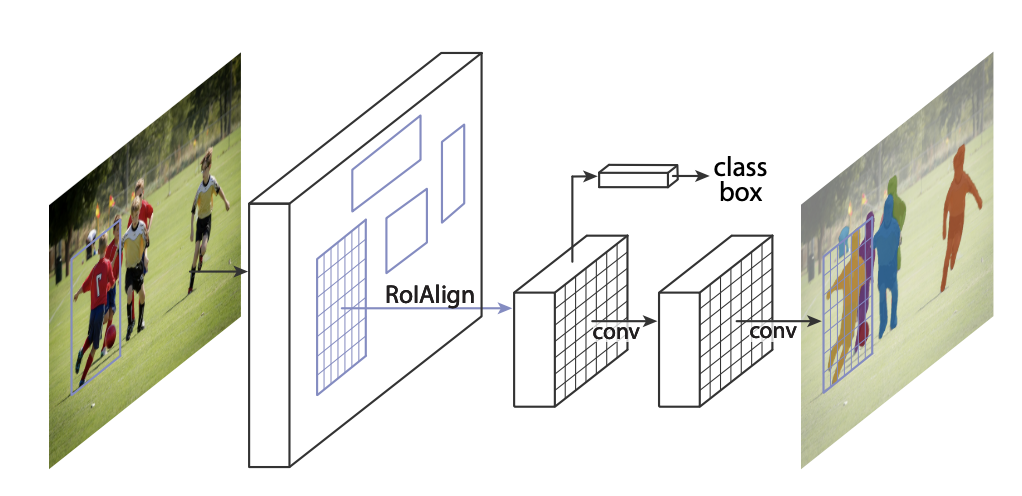

In [27]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [28]:
# Load the pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 46.0MB/s]


In [29]:
# Replace the classifier with a new one for your dataset
# Assuming num_classes is 81 (80 COCO classes + background)
num_classes = 81  # Update this based on your dataset

In [30]:
# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

In [31]:
# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Now the model is ready to be fine-tuned on our dataset.

##**3. Model Modification**

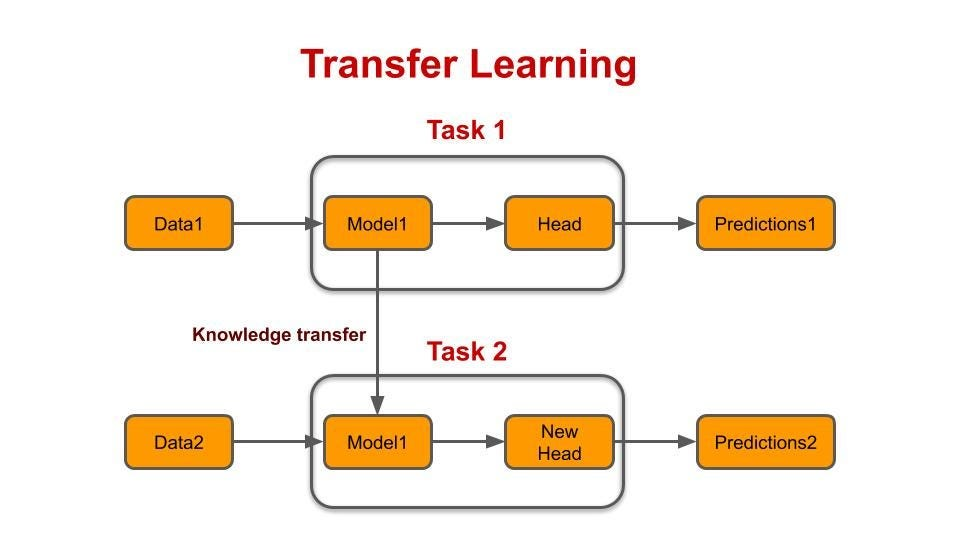

###**Can be Skipped at the Moment!!!!!**

##**4. Training Setup**

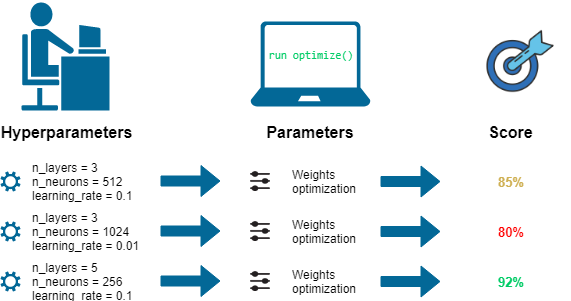

In [32]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import cv2
from torchvision.transforms import functional as F

In [33]:
# Training parameters
params = {
    "lr": 0.005,
    "momentum": 0.9,
    "weight_decay": 0.0005,
    "step_size": 3,
    "gamma": 0.1,
    "num_epochs": 10,
}

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [35]:
# Optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=params["momentum"], weight_decay=params["weight_decay"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params["step_size"], gamma=params["gamma"])

In [36]:
# # Assume custom Dataset class for loading data is defined elsewhere
# # Define your transformations, e.g., resizing, normalizing
# def transform_image(image):
#     # Convert the image from OpenCV BGR to RGB format and then to tensor
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     return F.to_tensor(image)

In [37]:
import os

In [38]:
model_save_path = '/content/drive/MyDrive/MAVISOFT/TRAINED_MODEL'  # Define the directory to save the models
# os.makedirs(model_save_path, exist_ok=True)  # Create the directory if it does not exist

In [39]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import cv2
from torchvision.transforms.functional import to_tensor

In [42]:
# import torch
# from torchvision.ops import box_iou

# def evaluate(model, data_loader, device):
#     model.eval()
#     ious = []
#     with torch.no_grad():
#         for images, targets in data_loader:
#             images = list(img.to(device) for img in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#             outputs = model(images)

#             for i, output in enumerate(outputs):
#                 pred_boxes = output['boxes']
#                 target_boxes = targets[i]['boxes']

#                 # Compute IoU
#                 iou = box_iou(target_boxes, pred_boxes)
#                 ious.append(iou.mean().item())

#     model.train()
#     return sum(ious) / len(ious)

# # Assuming params, device, optimizer, and scheduler are already defined
# for epoch in range(params['num_epochs']):
#     model.train()
#     total_loss = 0

#     # Training phase
#     for i, (image, target_dict) in enumerate(zip(x_train, y_train)):
#         image_tensor = to_tensor(image).unsqueeze(0).to(device)  # Convert image to tensor and add batch dimension

#         # Format targets for model
#         targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in target_dict.items()}]

#         optimizer.zero_grad()
#         loss_dict = model(image_tensor, targets)  # Assume single image per batch
#         losses = sum(loss for loss in loss_dict.values())

#         if torch.isnan(losses).any():
#             print(f"NaN loss detected at epoch {epoch+1}, batch {i+1}. Skipping this batch.")
#             continue

#         losses.backward()
#         optimizer.step()
#         total_loss += losses.item()

#         if i % 100 == 0:
#             print(f"Epoch {epoch+1}, Batch {i+1}, Current Loss: {losses.item()}")

#     avg_loss = total_loss / (i + 1)
#     print(f"Epoch {epoch+1} Completed, Avg Loss: {avg_loss}")

#     # Validation phase
#     val_data_loader = torch.utils.data.DataLoader(list(zip(x_val, y_val)), batch_size=1, shuffle=False)
#     iou = evaluate(model, val_data_loader, device)
#     print(f"Epoch {epoch+1}, Validation IoU: {iou}")

#     scheduler.step()

#     # Save model checkpoint
#     checkpoint_filename = f"model_epoch_{epoch+1}.pth"
#     checkpoint_path = os.path.join(model_save_path, checkpoint_filename)
#     torch.save(model.state_dict(), checkpoint_path)
#     print(f"Model saved to {checkpoint_path}")

In [ ]:
# Assuming params, device, optimizer, and scheduler are already defined
for epoch in range(params['num_epochs']):
    model.train()
    total_loss = 0
    for i, (image, target_dict) in enumerate(zip(x_train, y_train)):
        # Convert image to tensor and permute dimensions
        image_tensor = to_tensor(image).unsqueeze(0).to(device)  # Add batch dimension back

        # Format targets for model
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in target_dict.items()}]

        optimizer.zero_grad()
        # loss_dict = model([image_tensor], targets)
        loss_dict = model(image_tensor, targets)
        losses = sum(loss for loss in loss_dict.values())

        if torch.isnan(losses):
            print(f"NaN loss detected at epoch {epoch+1}, batch {i+1}.")
            print("Loss dict:", loss_dict)
            print("Skipping this batch.")
            continue  # Skip this batch

        total_loss += losses.item()
        losses.backward()
        optimizer.step()

        if i % 100 == 0:  # Print loss every 100 batches
            print(f"Epoch {epoch+1}, Batch {i+1}, Current Loss: {losses.item()}")

    avg_loss = total_loss / (i + 1)
    print(f"Epoch {epoch+1} Completed, Avg Loss: {avg_loss}")
    scheduler.step()

    # Save the model checkpoint at the end of each epoch
    checkpoint_filename = f"model_epoch_{epoch+1}.pth"
    checkpoint_path = os.path.join(model_save_path, checkpoint_filename)
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model saved to {checkpoint_path}")

Epoch 1, Batch 1, Current Loss: 5.202371120452881
Epoch 1, Batch 101, Current Loss: 0.4594464898109436
Epoch 1, Batch 201, Current Loss: 0.5512852072715759
Epoch 1, Batch 301, Current Loss: 0.733214259147644
Epoch 1, Batch 401, Current Loss: 0.2253708392381668
Epoch 1, Batch 501, Current Loss: 1.409050703048706
Epoch 1, Batch 601, Current Loss: 0.30422243475914


##**5. Model Training**

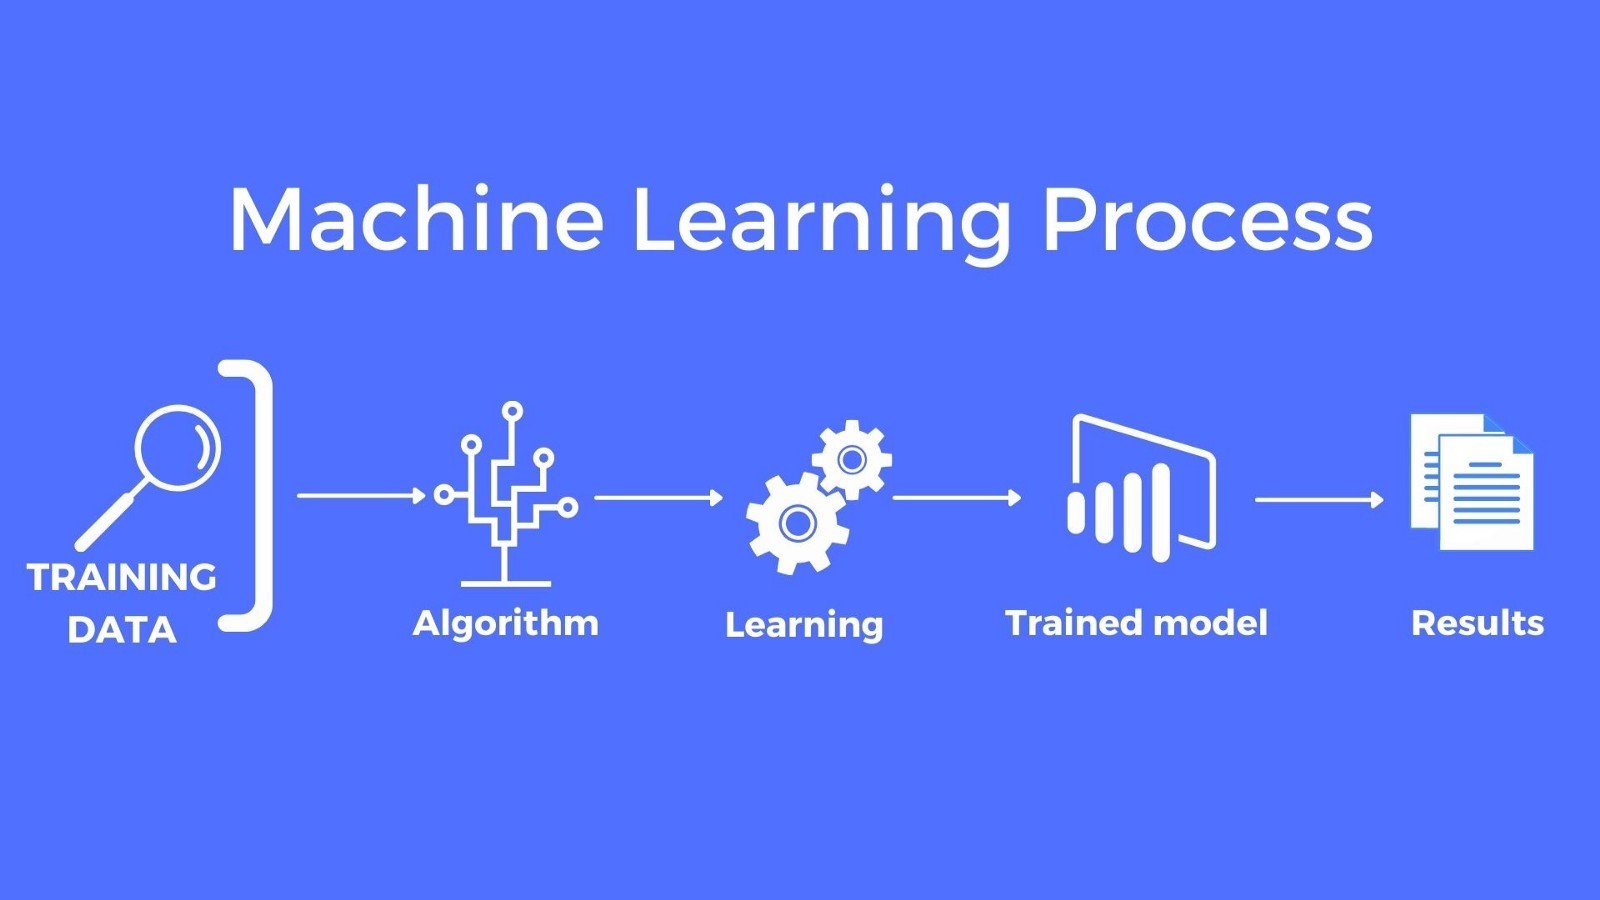

##**6. Model Evaluation**


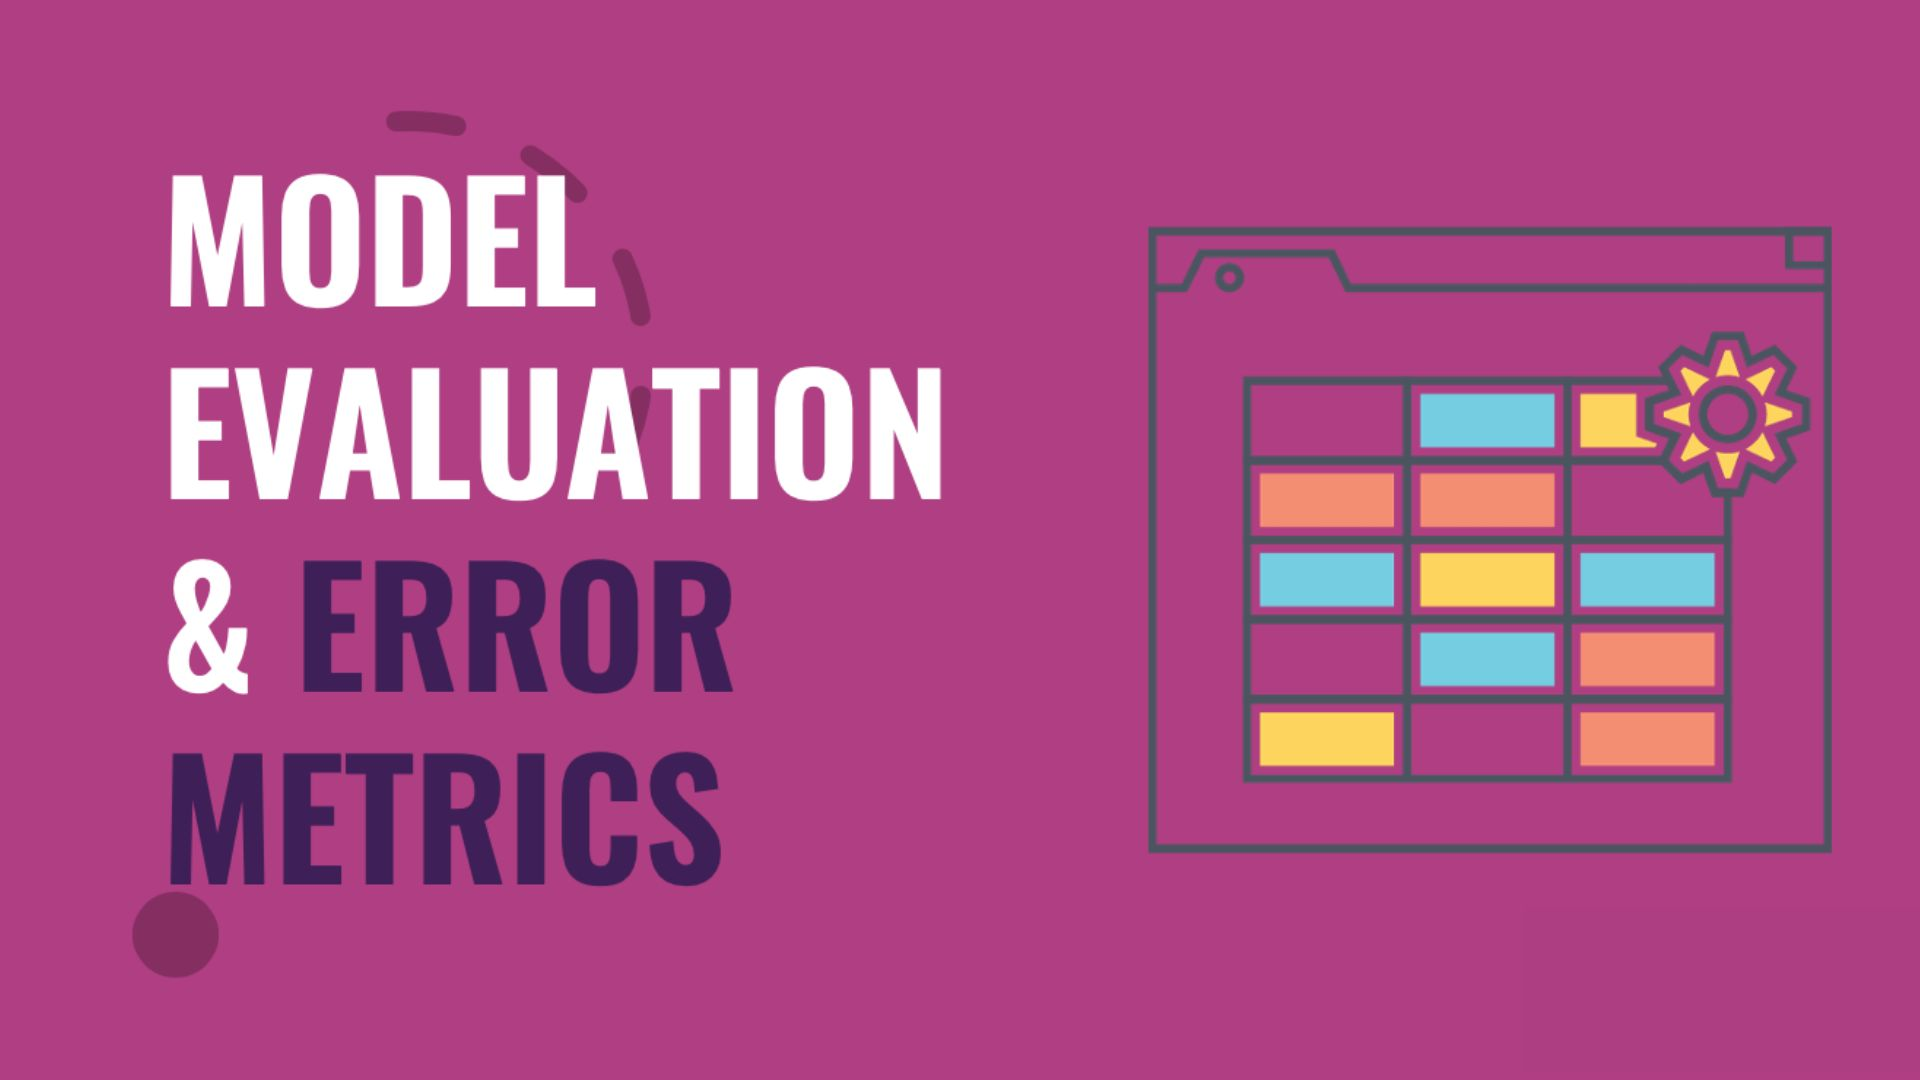

##**7. Visualization**

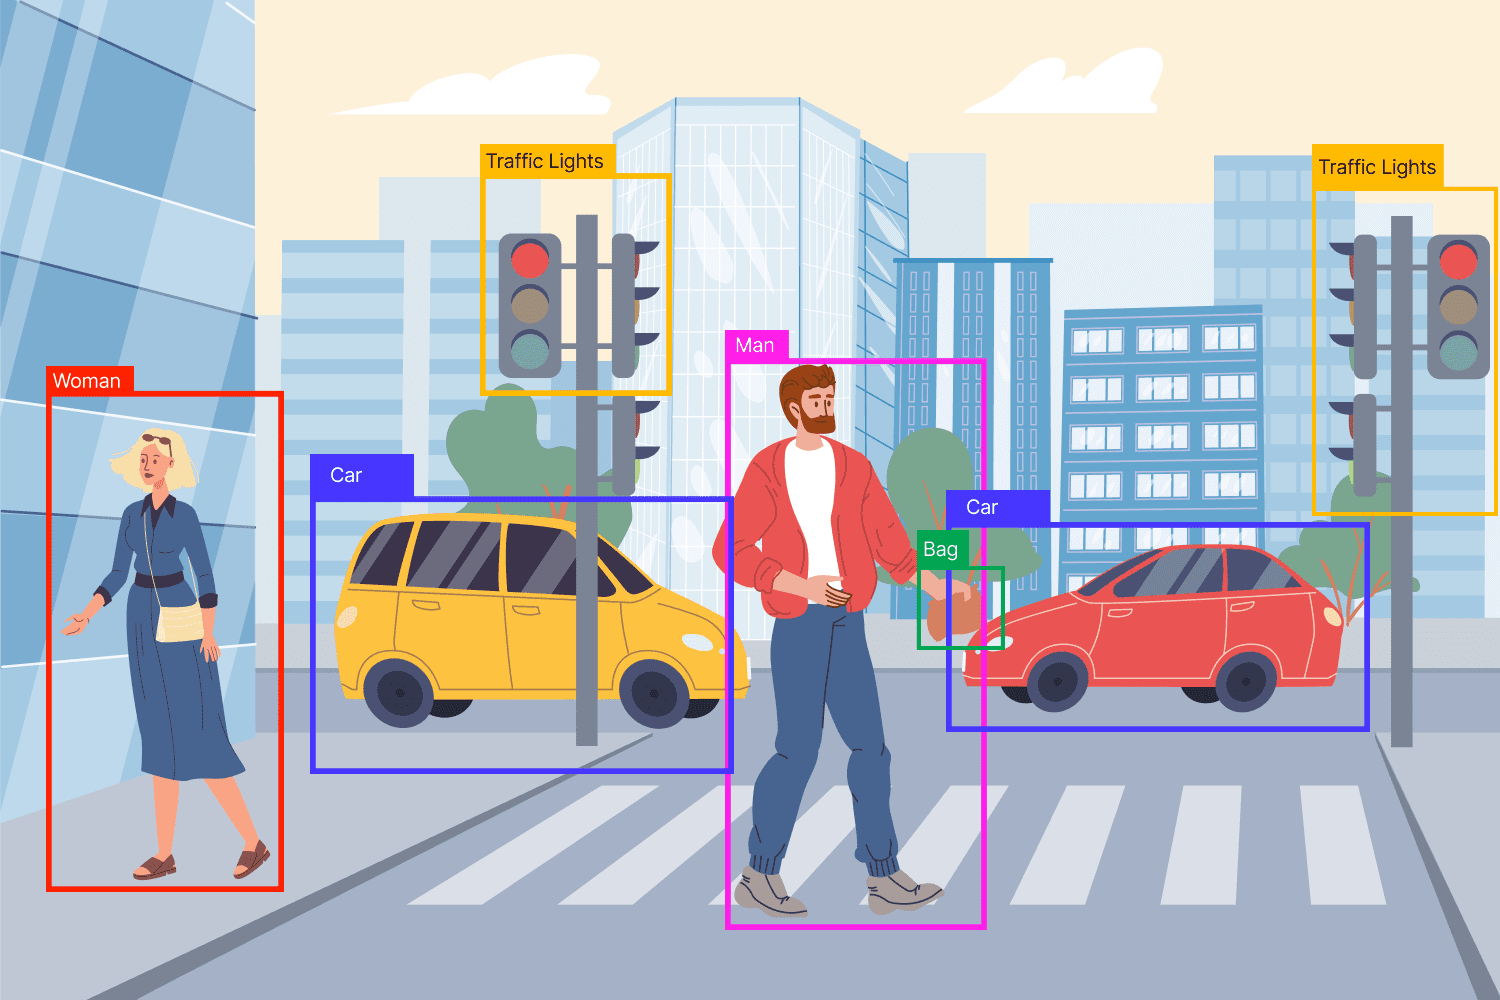

#**The End**